# Entrainement des modèles en approche supervisée

In [1]:
import pandas as pd
import pickle

# Chargement des DataFrames à partir des fichiers pickle
filtered_tokenized_vs_original = pd.read_pickle('filtered_tokenized_vs_original.pkl')
top200_tags = pd.read_pickle('top200_tags.pkl')
tfidf_data = pd.read_pickle('tfidf_data.pkl')
first_200_tags = pd.read_pickle('first_200_tags.pkl')
tfidf_vectorizer = pd.read_pickle('tfidf_vectorizer.pkl')
vocabulary = pd.read_pickle('vocabulary.pkl')

In [15]:
filtered_tokenized_vs_original

,Post,splitted_text,splitted_tags
6,react router v5 2 blocking route change with...,"[image, class, code, image, code, display, ima...","[reactjs, next, tailwind, nextjs, image]"
12,rolling idxmin max for pandas dataframe p i b...,"[validity, lifetime, extension, initializer, i...","[language, lawyer, lifetime, temporary, object]"
15,process finished with exit code 137 interrupt...,"[solidity, star, name, address, contract, soli...","[blockchain, ethereum, solidity, smartcontracts]"
26,flutter web text field scrolls instead of se...,"[error, flutter, video, player, player, chewie...","[flutter, dart, flutter, video, player]"
48,can t scrape all the company names from a webp...,"[memory, base, address, code, post, bootloader...","[linux, linux, kernel, kernel, architecture]"
...,...,...,...
21763,NaN,"[event, javascript, href, shake, event, javasc...","[javascript, mobile, accelerometer, shake]"
21764,NaN,"[practice, session, project, company, minute, ...",[nuxt]
21765,NaN,"[gesture, course, mosh, href, http, codewithmo...","[javascript, android, react, native, expo, ges..."
21766,NaN,"[image, treeline, crop, direction, crop, hough...","[python, numpy, opencv, hough, transform]"


# Dédoublonnage des labels

In [2]:
dedup_tags = []
for tags in top200_tags:
    dedup_tags.append(set(tags))

print('Affichage de la première occurence de dedup_tags')
display(dedup_tags[0])

Affichage de la première occurence de dedup_tags


{'javascript', 'react', 'reactjs', 'router'}

# split des données en train/test

In [3]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(tfidf_data, dedup_tags, test_size=0.2, random_state=42)

# Réduction des données

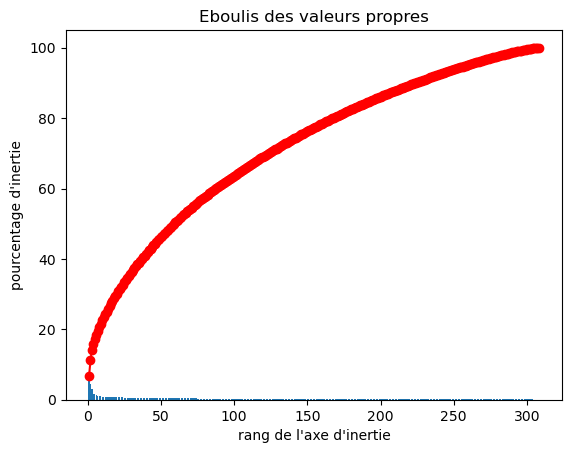

In [4]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

pca = PCA(random_state=42)
pca.fit(X_train)

def display_scree_plot(pca):
    scree = pca.explained_variance_ratio_*100
    plt.bar(np.arange(len(scree))+1, scree)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
    plt.xlabel("rang de l'axe d'inertie")
    plt.ylabel("pourcentage d'inertie")
    plt.title("Eboulis des valeurs propres")
    plt.show(block=False)

display_scree_plot(pca)

# pca avec 85% de la variance 

In [6]:
import pickle 
import os
pca = PCA(n_components=0.85, random_state=42)
pca.fit(X_train)
X_train_transformed = pca.transform(X_train)
X_test_transformed = pca.transform(X_test)
print(f"Nombre de composantes principales: {pca.components_.shape[0]}")


save_directory = "C:\\Users\\etern\\base Deep learning\\projet 5\\data"
filename_pca_model = os.path.join(save_directory, 'pca_model.pkl')
with open(filename_pca_model, 'wb') as file:
    pickle.dump(pca, file)

Nombre de composantes principales: 194


# Vectorisaton des labels

In [7]:
import os
import pickle
from sklearn.preprocessing import MultiLabelBinarizer


# Création et ajustement du modèle MultiLabelBinarizer
mlb = MultiLabelBinarizer(classes=first_200_tags)
train_labels = mlb.fit_transform(y_train)
test_labels = mlb.transform(y_test)

# Affichage des classes du modèle de vectorisation
print("Affichage des classes du modèle de vectorisation")
display(mlb.classes_)

# Spécification du répertoire de sauvegarde
save_directory = "C:\\Users\\etern\\base Deep learning\\projet 5\\data"
os.makedirs(save_directory, exist_ok=True)  # Crée le répertoire s'il n'existe pas déjà

# Enregistrement du modèle MultiLabelBinarizer
filename_mlb_model = os.path.join(save_directory, 'mlb_model.pkl')
with open(filename_mlb_model, 'wb') as file:
    pickle.dump(mlb, file)

Affichage des classes du modèle de vectorisation


array(['python', 'android', 'javascript', 'java', 'google', 'reactjs',
       'react', 'studio', 'flutter', 'azure', 'amazon', 'node', 'spring',
       'docker', 'visual', 'core', 'compose', 'typescript', 'cloud',
       'service', 'firebase', 'kotlin', 'jetpack', 'code', 'swift',
       'native', 'next', 'github', 'angular', 'html', 'django',
       'kubernetes', 'boot', 'data', 'window', 'apache', 'macos', 'dart',
       'linux', 'language', 'type', 'laravel', 'function', 'swiftui',
       'xcode', 'testing', 'gradle', 'framework', 'server', 'lawyer',
       'panda', 'chrome', 'algorithm', 'template', 'platform', 'json',
       'webpack', 'ruby', 'spark', 'array', 'tensorflow', 'rust', 'apple',
       'performance', 'gitlab', 'postgresql', 'router', 'memory',
       'blazor', 'numpy', 'lambda', 'module', 'selenium', 'navigation',
       'rail', 'authentication', 'action', 'material', 'image',
       'dataframe', 'learning', 'scala', 'hook', 'redux', 'optimization',
       'entity', '

# Fonction d'évaluation des modèles

In [8]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, hamming_loss

models_performance = {}

def metrics_report(model_name, test_labels, predictions, performances):
    """
    Compute performance metrics of a model and store them in a dictionary
    
    Args:
        model_name(string): name of the evaluated model
        test_labels(array): labels related to predictors
        preductions(array): predicted results
        performances(dict): used dictionary to store metrics
    Returns:
        performances(dict): used dictionary to store metrics filed with models ones
    """    
    accuracy = accuracy_score(test_labels, predictions)
    macro_precision = precision_score(test_labels, predictions, average='macro')
    macro_recall = recall_score(test_labels, predictions, average='macro')
    macro_f1 = f1_score(test_labels, predictions, average='macro')
    micro_precision = precision_score(test_labels, predictions, average='micro')
    micro_recall = recall_score(test_labels, predictions, average='micro')
    micro_f1 = f1_score(test_labels, predictions, average='micro')
    hamLoss = hamming_loss(test_labels, predictions)
    print("------" + model_name + " Model Metrics-----")
    print("Accuracy: {:.4f}\nHamming Loss: {:.4f}\nPrecision:\n  - Macro: {:.4f}\n  - Micro: {:.4f}\nRecall:\n  - Macro: {:.4f}\n  - Micro: {:.4f}\nF1-measure:\n  - Macro: {:.4f}\n  - Micro: {:.4f}"\
          .format(accuracy, hamLoss, macro_precision, micro_precision, macro_recall, micro_recall, macro_f1, micro_f1))
    
    performances[model_name] = {}
    performances[model_name]["micro_precision"] =  micro_precision
    performances[model_name]["micro_recall"] = micro_recall
    performances[model_name]["micro_f1"] = micro_f1
    
    return performances

# KNN

In [11]:
from sklearn.neighbors import KNeighborsClassifier
import mlflow
import mlflow.sklearn
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, hamming_loss
import time

# Définissez le nom de l'expérience (facultatif)
mlflow.set_experiment("KNN")

# ...


# Démarrez une expérience MLflow
with mlflow.start_run():

    # Enregistrez le temps de début
    start_time = time.time()

    # Votre code
    knn_clf = KNeighborsClassifier()
    knn_clf.fit(X_train_transformed, train_labels)
    knn_predictions = knn_clf.predict(X_test_transformed)
    
    # Appel de la fonction metrics_report
    models_performance = metrics_report("knn", test_labels, knn_predictions, models_performance)
    
    # Enregistrez les métriques dans MLflow
    mlflow.log_metrics(models_performance["knn"])
    
    # Enregistrez le modèle dans MLflow
    mlflow.sklearn.log_model(knn_clf, "model")

    # Enregistrez le temps de fin
    end_time = time.time()

    # Calcul du temps total d'exécution
    execution_time = end_time - start_time

    # Enregistrez le temps d'exécution dans MLflow en tant que métrique
    mlflow.log_metric("execution_time", execution_time)

# Fin de l'expérience MLflow
mlflow.end_run()



C:\Users\etern\anaconda3v2\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


------knn Model Metrics-----
Accuracy: 0.0638
Hamming Loss: 0.0119
Precision:
  - Macro: 0.3722
  - Micro: 0.6446
Recall:
  - Macro: 0.1090
  - Micro: 0.1921
F1-measure:
  - Macro: 0.1572
  - Micro: 0.2960


# SVM

In [14]:
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier
import mlflow
import mlflow.sklearn
import time

# Démarrez une expérience MLflow pour le modèle SVM
mlflow.set_experiment("SVM")
with mlflow.start_run():

    # Enregistrez le temps de début
    start_time = time.time()

    # Votre code
    svm_clf = OneVsRestClassifier(LinearSVC(), n_jobs=-1)
    svm_clf.fit(X_train_transformed, train_labels)
    svm_preds = svm_clf.predict(X_test_transformed)

    # Appel de la fonction metrics_report pour SVM
    models_performance = metrics_report("svm", test_labels, svm_preds, models_performance)

    # Enregistrez les métriques dans MLflow
    mlflow.log_metrics(models_performance["svm"])

    # Enregistrez le modèle dans MLflow
    mlflow.sklearn.log_model(svm_clf, "model")

    # Enregistrez le temps de fin
    end_time = time.time()

    # Calcul du temps total d'exécution
    execution_time = end_time - start_time

    # Enregistrez le temps d'exécution dans MLflow en tant que métrique
    mlflow.log_metric("execution_time", execution_time)

    # Enregistrez le modèle dans le Model Registry
    mlflow.register_model(f"runs:/{mlflow.active_run().info.run_id}/model", "SVM_Model")


C:\Users\etern\anaconda3v2\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


------svm Model Metrics-----
Accuracy: 0.0845
Hamming Loss: 0.0107
Precision:
  - Macro: 0.3431
  - Micro: 0.7865
Recall:
  - Macro: 0.1228
  - Micro: 0.2450
F1-measure:
  - Macro: 0.1656
  - Micro: 0.3736


Successfully registered model 'SVM_Model'.
Created version '1' of model 'SVM_Model'.


# Random Forest

In [13]:
from sklearn.ensemble import RandomForestClassifier
import mlflow
import mlflow.sklearn
import time

# ...
mlflow.set_experiment("Random Forest")
# Démarrez une expérience MLflow pour le modèle Random Forest
with mlflow.start_run():

    # Enregistrez le temps de début
    start_time = time.time()

    # Votre code
    rf_clf = RandomForestClassifier(n_jobs=-1)
    rf_clf.fit(X_train_transformed, train_labels)
    rf_preds = rf_clf.predict(X_test_transformed)

    # Appel de la fonction metrics_report pour le Random Forest
    models_performance = metrics_report("Random Forest", test_labels, rf_preds, models_performance)

    # Enregistrez les métriques dans MLflow
    mlflow.log_metrics(models_performance["Random Forest"])

    # Enregistrez le modèle dans MLflow
    mlflow.sklearn.log_model(rf_clf, "model")

    # Enregistrez le temps de fin
    end_time = time.time()

    # Calcul du temps total d'exécution
    execution_time = end_time - start_time

    # Enregistrez le temps d'exécution dans MLflow en tant que métrique
    mlflow.log_metric("execution_time", execution_time)

# Fin de l'expérience MLflow
mlflow.end_run()


2024/03/04 14:15:05 INFO mlflow.tracking.fluent: Experiment with name 'Random Forest' does not exist. Creating a new experiment.
C:\Users\etern\anaconda3v2\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


------Random Forest Model Metrics-----
Accuracy: 0.0331
Hamming Loss: 0.0120
Precision:
  - Macro: 0.1749
  - Micro: 0.8834
Recall:
  - Macro: 0.0271
  - Micro: 0.0851
F1-measure:
  - Macro: 0.0426
  - Micro: 0.1553


# affichage résultats

In [ ]:
result_df = pd.DataFrame.from_dict(models_performance, orient="index")
result_df

# sauvegarde meilleurs modèles: random forest

In [ ]:
save_directory = "C:\\Users\\etern\\base Deep learning\\projet 5\\data"
filename_svm_model = os.path.join(save_directory, 'svm_model.pkl')
with open(filename_svm_model, 'wb') as file:
    pickle.dump(svm_clf, file)


# Fonction de prédiction

In [ ]:
%%time
def predict_supervised_tags(supervised_model, mlb_model, text):
    """
    Predict tags according to a lemmatized text using a supervied model.
    
    Args:
        supervised_model(): Used mode to get prediction
        mlb_model(): Used model to detransform
    Returns:
        res(list): List of predicted tags
    """
    res = tfidf_vectorizer.transform(text)
    res = pd.DataFrame(res.toarray(), columns=vocabulary)
    res = pca.transform(res)
    res = supervised_model.predict(res)
    res = mlb.inverse_transform(res)
    res = list({tag for tag_list in res for tag in tag_list if (len(tag_list) != 0)})
    res = [tag for tag  in res if tag in text]
    
    return res

# Fonction de vérification

In [ ]:
filtered_tokenized_vs_original_1 = filtered_tokenized_vs_original.dropna(subset=['Post']).reset_index(drop=True)


In [ ]:
def check_tag_predction(original_text, original_tags, preprocessed_text, model):
    """
    Check original tags vs predicted tags for a post.
    
    Args:
        post(list) : original text
        original_tags(list) : preprocessed_tags
    """
    
    predicted_tags = predict_supervised_tags(model, mlb, preprocessed_text)
    print("Publication originale: \n")
    print(f"{original_text}")
    print("\n")
    print(f"Liste des tags pré-traités utilisés par l'utilisateur: {original_tags}")
    print("\n")
    print(f"Liste des tags prédits par le modèle: {predicted_tags}")

check_tag_predction(filtered_tokenized_vs_original_1.loc[100,'Post'], 
                filtered_tokenized_vs_original.loc[100,'splitted_tags'],
                filtered_tokenized_vs_original.loc[100,'splitted_text'],
                svm_clf)

In [ ]:
pca

In [ ]:
import pickle

# Sauvegarde du modèle SVM avec pickle
with open('svm_clf.pkl', 'wb') as f:
    pickle.dump(svm_clf, f)


with open('mlb.pkl', 'wb') as f:
    pickle.dump(mlb, f)
    
with open('pca.pkl', 'wb') as f:
    pickle.dump(pca, f)
        